In [ ]:
%pip install tensorflow matplotlib tensorflowjs[wizard]

In [1]:
# Reference from https://www.tensorflow.org/tutorials/keras/text_classification
import tensorflow as tf
import tensorflowjs as tfjs
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import layers, utils, losses, optimizers

In [2]:
max_features = 30000
sequence_length = 128

In [3]:
vocab_dataset = tf.data.TextLineDataset('./idwiki_vocab.txt').filter(lambda x: tf.cast(tf.strings.length(x), bool))

In [4]:
vectorize_layer = layers.TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)
vectorize_layer.adapt(vocab_dataset.batch(2048))

In [5]:
vectorize_layer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 30000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 128,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [6]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [196]:
seed = 44
raw_train_dataset = utils.text_dataset_from_directory(
    './dataset/', 
    validation_split=0.061,
    label_mode='categorical',
    subset='training',
    seed=seed)
raw_validation_dataset = utils.text_dataset_from_directory(
    './dataset/', 
    validation_split=0.061,
    label_mode='categorical',
    subset='validation',
    seed=seed)

Found 210 files belonging to 6 classes.
Using 198 files for training.
Found 210 files belonging to 6 classes.
Using 12 files for validation.


In [197]:
for text_batch, label_batch in raw_train_dataset.take(1):
  for i in range(10):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])
    print("Vectorized review", vectorize_text(text_batch.numpy()[i], label_batch.numpy()[i]))

Review b'Saya ingin mengunduh video dari Instagram dan menyimpannya di perangkat saya. Bagaimana caranya di bot ini?'
Label [1. 0. 0. 0. 0. 0.]
Vectorized review (<tf.Tensor: shape=(1, 128), dtype=int64, numpy=
array([[  914,   701, 19118,   326,     6,  4695,     2, 28367,     4,
          795,   914,  1415, 12105,     4, 13694,     8,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
        

In [198]:
class_name = raw_train_dataset.class_names

In [199]:
class_name

['instagram', 'owner', 'sticker', 'tiktok', 'twitter', 'youtube']

In [200]:
# text_batch, label_batch = next(iter(raw_train_dataset))
# first_review, first_label = text_batch[0], label_batch[0]
# label_as_list = first_label.numpy().tolist()
# print("Review", first_review)
# print("Label", class_name[label_as_list.index(max(label_as_list))])
# print("Vectorized review", vectorize_text(first_review, first_label))

In [201]:
train_dataset = raw_train_dataset.map(vectorize_text)
validation_dataset = raw_validation_dataset.map(vectorize_text)


In [202]:
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [203]:
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, 64, mask_zero=True),
    layers.Dropout(0.1),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_name), activation='softmax')
])
model.compile(loss=losses.CategoricalCrossentropy(),
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])
model.summary()


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 64)          1920064   
                                                                 
 dropout_23 (Dropout)        (None, None, 64)          0         
                                                                 
 bidirectional_24 (Bidirecti  (None, None, 128)        66048     
 onal)                                                           
                                                                 
 bidirectional_25 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_24 (Dense)            (None, 64)                4160      
                                                                 
 dropout_24 (Dropout)        (None, 64)              

In [204]:
utils.plot_model(model, show_shapes=True, dpi=48)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [205]:
epochs = 20

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs)

Epoch 1/20
7/7 [==============================] - 23s 867ms/step - loss: 1.7922 - accuracy: 0.1162 - val_loss: 1.7849 - val_accuracy: 0.1667
Epoch 2/20
7/7 [==============================] - 1s 132ms/step - loss: 1.7831 - accuracy: 0.2172 - val_loss: 1.7728 - val_accuracy: 0.4167
Epoch 3/20
7/7 [==============================] - 1s 127ms/step - loss: 1.7615 - accuracy: 0.3283 - val_loss: 1.7311 - val_accuracy: 0.5833
Epoch 4/20
7/7 [==============================] - 1s 153ms/step - loss: 1.7008 - accuracy: 0.3788 - val_loss: 1.6166 - val_accuracy: 0.4167
Epoch 5/20
7/7 [==============================] - 1s 130ms/step - loss: 1.5729 - accuracy: 0.3687 - val_loss: 1.4141 - val_accuracy: 0.6667
Epoch 6/20
7/7 [==============================] - 1s 119ms/step - loss: 1.3336 - accuracy: 0.4495 - val_loss: 1.1238 - val_accuracy: 0.8333
Epoch 7/20
7/7 [==============================] - 1s 114ms/step - loss: 1.1373 - accuracy: 0.5909 - val_loss: 0.8705 - val_accuracy: 0.8333
Epoch 8/20
7/7 [===

In [206]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

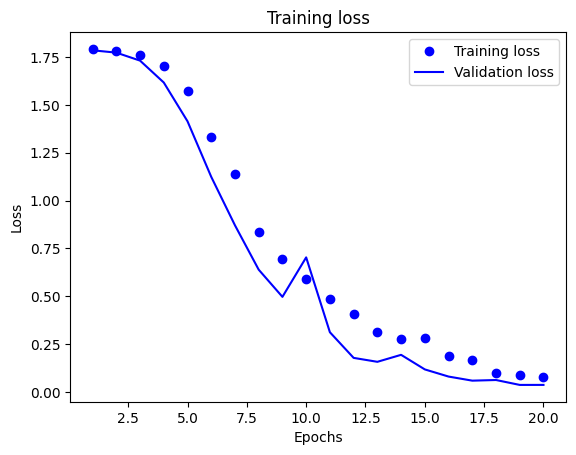

In [207]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

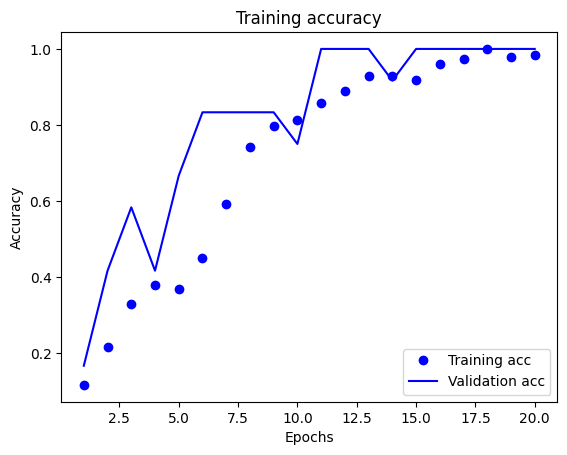

In [208]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [209]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model
])

export_model.compile(
    loss=losses.CategoricalCrossentropy(),
    optimizer=optimizers.Adam(),
    metrics=['accuracy'])


In [213]:
model.save("./model")

INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets


In [214]:
tfjs.converters.save_keras_model(model,
                                 "./model-tfjs/")


In [212]:
example = [
    "ubah foto tersebut menjadi stiker",
    "download sebuah video dari youtube",
    "bisakah kamu mengubah foto di atas menjadi sticker?",
    "dapatkah saya berbicara dengan owner anda untuk meminta bantuan?",
    "download video dari instagram",
    "unduhkan saya sebuah video dari tiktok",
    "saya mempunyai link video twitter, download video twitter tersebut"
]
predicted = export_model.predict(example)

for pred in predicted:
    index = predicted.tolist().index(pred.tolist())
    score = max(pred)
    higest_index = pred.tolist().index(score)
    print("Input:", example[index])
    print("Prediction:", pred)
    print("Predicted label:", class_name[higest_index], ":", score)
    print("")

1/1 [==============================] - 4s 4s/step
Input: ubah foto tersebut menjadi stiker
Prediction: [9.9314852e-03 4.5262352e-03 9.8081779e-01 3.0898494e-03 8.8556658e-04
 7.4896077e-04]
Predicted label: sticker : 0.9808178

Input: download sebuah video dari youtube
Prediction: [0.00852365 0.00956021 0.00211257 0.05286557 0.13509779 0.7918402 ]
Predicted label: youtube : 0.7918402

Input: bisakah kamu mengubah foto di atas menjadi sticker?
Prediction: [5.1159048e-03 1.7809017e-03 9.9201363e-01 8.1031601e-04 1.3802289e-04
 1.4112754e-04]
Predicted label: sticker : 0.99201363

Input: dapatkah saya berbicara dengan owner anda untuk meminta bantuan?
Prediction: [2.1146908e-03 9.9464685e-01 1.3551405e-03 5.5049284e-05 1.5782056e-05
 1.8124613e-03]
Predicted label: owner : 0.99464685

Input: download video dari instagram
Prediction: [0.8207323  0.04137225 0.05571517 0.074838   0.0035876  0.00375473]
Predicted label: instagram : 0.8207323

Input: unduhkan saya sebuah video dari tiktok
Pred